# (1) Airlines Data 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_excel("D:\Assignment\Forecasting\Airlines+Data.xlsx",index_col=0, parse_dates=True)

In [3]:
df

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


In [4]:
df.shape

(96, 1)

In [5]:
df.isna().sum()

Passengers    0
dtype: int64

In [6]:
df.duplicated().sum()

16

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.duplicated().sum()

0

In [9]:
df.describe()

,Passengers
count,80.000000
mean,215.975000
std,75.588489
min,104.000000
25%,149.750000
50%,202.000000
75%,270.250000
max,413.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80 entries, 1995-01-01 to 2002-11-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  80 non-null     int64
dtypes: int64(1)
memory usage: 1.2 KB


In [11]:
df.ndim

2

<AxesSubplot: xlabel='Month'>

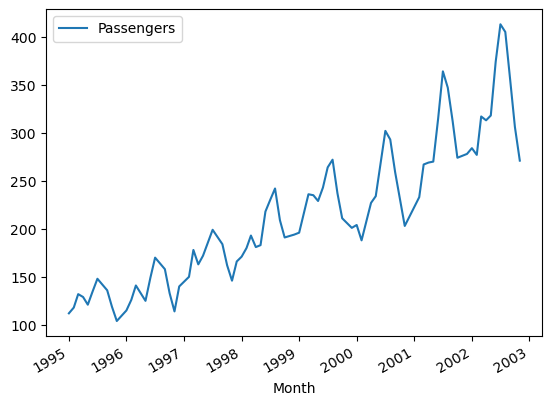

In [12]:
df.plot()

**here we can say that the trend is upward and the sessionality is multiplicative**

<AxesSubplot: ylabel='Density'>

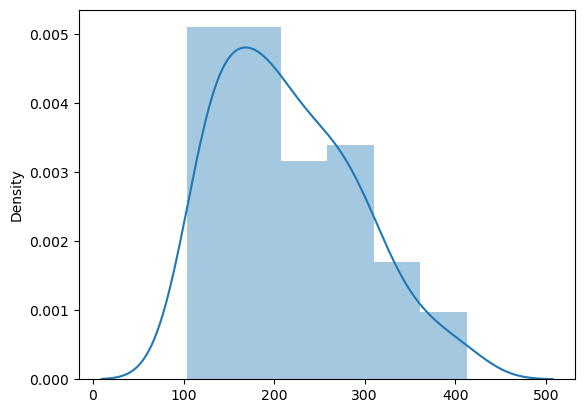

In [13]:
sns.distplot(df)

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

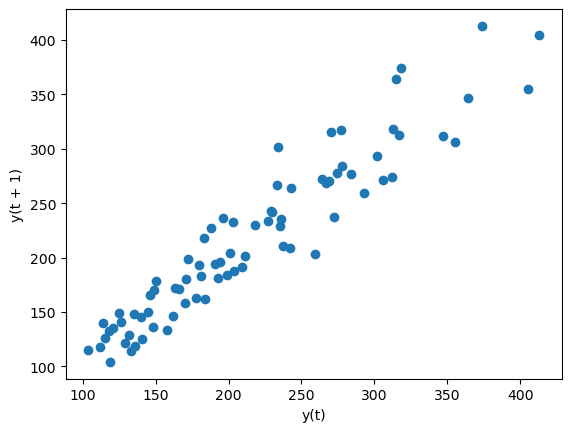

In [14]:
lag_plot(df)

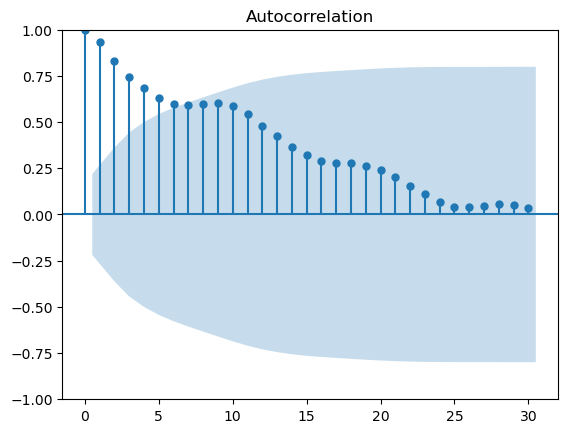

In [15]:
#Autocorrelation Plot

plot_acf(df,lags=30)
plt.show()

### UpSampling

In [16]:
upsampled = df.resample('M').mean()
print(upsampled.head(20))

            Passengers
Month                 
1995-01-31       112.0
1995-02-28       118.0
1995-03-31       132.0
1995-04-30       129.0
1995-05-31       121.0
1995-06-30       135.0
1995-07-31       148.0
1995-08-31         NaN
1995-09-30       136.0
1995-10-31       119.0
1995-11-30       104.0
1995-12-31         NaN
1996-01-31       115.0
1996-02-29       126.0
1996-03-31       141.0
1996-04-30         NaN
1996-05-31       125.0
1996-06-30       149.0
1996-07-31       170.0
1996-08-31         NaN


            Passengers
Month                 
1995-01-31       112.0
1995-02-28       118.0
1995-03-31       132.0
1995-04-30       129.0
1995-05-31       121.0
1995-06-30       135.0
1995-07-31       148.0
1995-08-31       142.0
1995-09-30       136.0
1995-10-31       119.0
1995-11-30       104.0
1995-12-31       109.5
1996-01-31       115.0
1996-02-29       126.0
1996-03-31       141.0
1996-04-30       133.0
1996-05-31       125.0
1996-06-30       149.0
1996-07-31       170.0
1996-08-31       164.0


<AxesSubplot: xlabel='Month'>

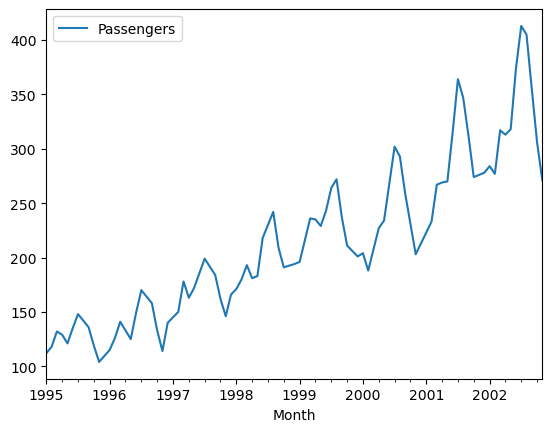

In [17]:
## interplation was done for nan values which we get after doing upsampling by month

interpolated_df = upsampled.interpolate(method='linear') 
print(interpolated_df.head(20))
interpolated_df.plot()

### Tranformations

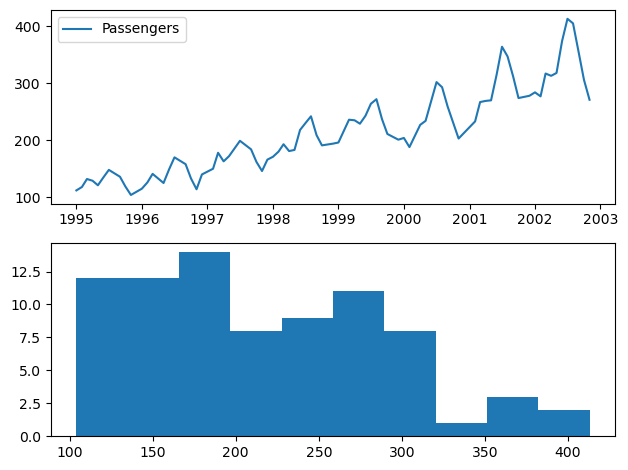

In [18]:
#Line plot
plt.subplot(2, 1, 1)
plt.plot(df)
plt.legend(df)

# histogram
plt.subplot(2, 1, 2)
plt.hist(df)

plt.tight_layout()

### Square Root Transform

In [19]:
sqrt_df = pd.DataFrame(df.values,columns=['Passengers'])
sqrt_df['Passengers'] = np.sqrt(sqrt_df['Passengers'])

<AxesSubplot: xlabel='Passengers', ylabel='Density'>

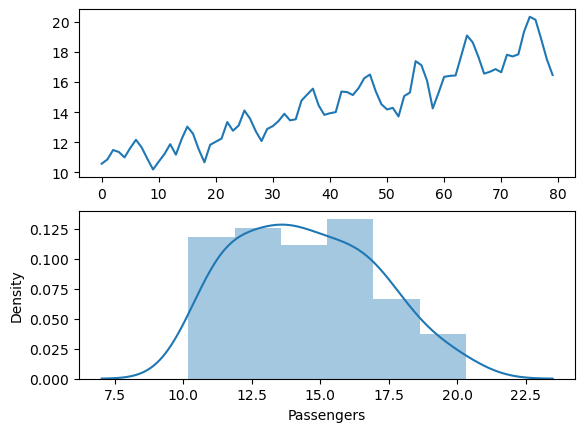

In [20]:
# line plot
plt.subplot(2, 1, 1)
plt.plot(sqrt_df['Passengers'])

# histogram
plt.subplot(2, 1, 2)
sns.distplot(sqrt_df['Passengers'])

### Log Transform

In [21]:
log_df = pd.DataFrame(df.values,columns=['Passengers'])
log_df['Passengers'] = np.log(log_df['Passengers'])

<AxesSubplot: xlabel='Passengers', ylabel='Density'>

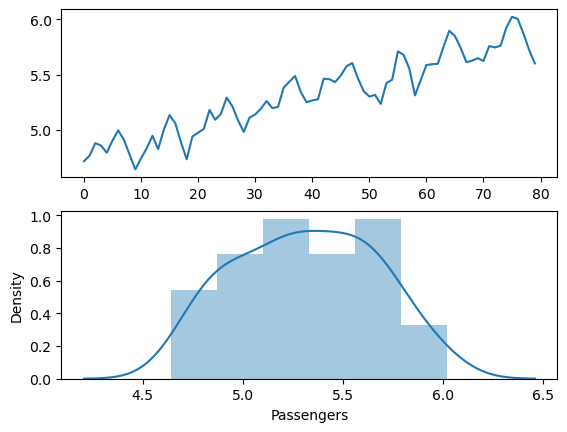

In [22]:
# line plot
plt.subplot(2, 1, 1)
plt.plot(log_df['Passengers'])

# histogram
plt.subplot(2, 1, 2)
sns.distplot(log_df['Passengers'])

In [23]:
interpolated_df.shape

(95, 1)

In [24]:
train = interpolated_df.iloc[:-20]
test = interpolated_df.iloc[-20:]

In [25]:
train

,Passengers
Month,
1995-01-31,112.0
1995-02-28,118.0
1995-03-31,132.0
1995-04-30,129.0
1995-05-31,121.0
...,...
2000-11-30,203.0
2000-12-31,213.0
2001-01-31,223.0


In [26]:
test

,Passengers
Month,
2001-04-30,269.0
2001-05-31,270.0
2001-06-30,315.0
2001-07-31,364.0
2001-08-31,347.0
2001-09-30,312.0
2001-10-31,274.0
2001-11-30,276.0
2001-12-31,278.0


### Moving Average

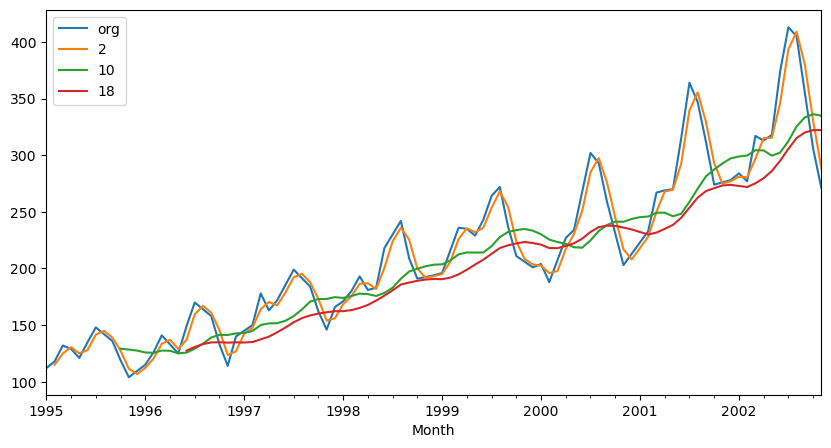

In [27]:
plt.figure(figsize=(10,5))
interpolated_df.Passengers.plot(label="org")
for i in range(2,20,8):
    interpolated_df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

### Time series decomposition plot

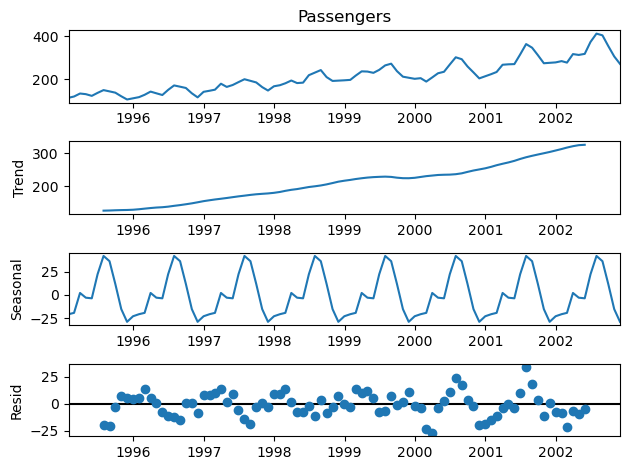

In [28]:
decompose_ts_add = seasonal_decompose(interpolated_df.Passengers)  
decompose_ts_add.plot()
plt.show()

## ACF plots and PACF plots

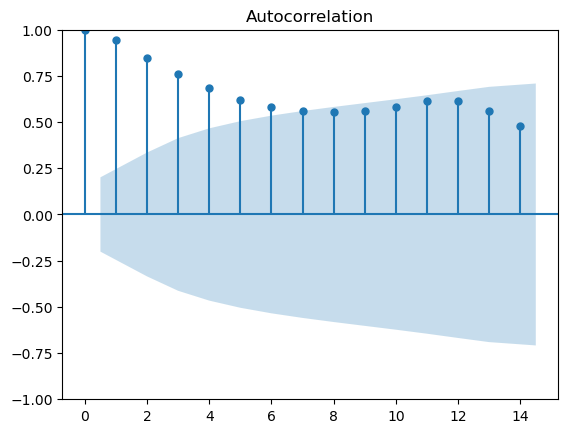

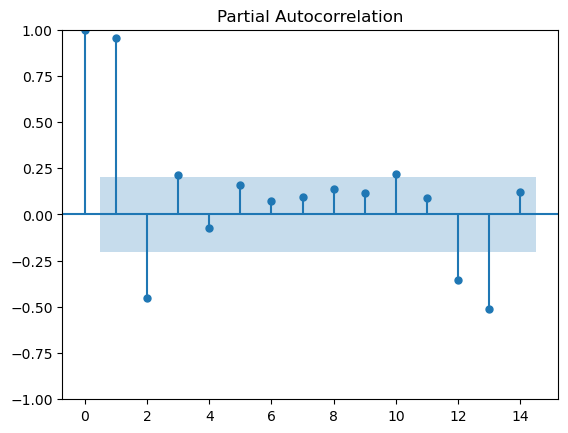

In [29]:
plot_acf(interpolated_df.Passengers,lags=14)
plot_pacf(interpolated_df.Passengers,lags=14)
plt.show()

## Model Evaluation

#### Simple Exponential Method

In [30]:
se_model = SimpleExpSmoothing(train["Passengers"]).fit(smoothing_level=0.2)
pred_se = se_model.predict(start=test.index[0], end=test.index[-1])

test['Passengers'].mean()
rmse=sqrt(mean_squared_error(pred_se,test['Passengers']))
mape = mean_absolute_percentage_error(pred_se,test['Passengers'])
print('RMSE :', rmse)
print('MAPE :', mape)

RMSE : 89.23065684120485
MAPE : 0.3234038140481998


#### Holt method

In [31]:
ht_model = Holt(train["Passengers"]).fit(smoothing_level=0.1, smoothing_slope=0.2)
pred_ht = ht_model.predict(start = test.index[0],end = test.index[-1])

test['Passengers'].mean()
rmse=sqrt(mean_squared_error(pred_ht,test['Passengers']))
mape = mean_absolute_percentage_error(pred_ht,test['Passengers'])
print('RMSE :', rmse)
print('MAPE :', mape)

RMSE : 83.64211458070115
MAPE : 0.289419238933823


#### Holts winter exponential smoothing with additive seasonality and additive trend

In [32]:
hwe_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.2)
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])

rmse=sqrt(mean_squared_error(pred_hwe_add_add,test['Passengers']))
mape = mean_absolute_percentage_error(pred_hwe_add_add,test['Passengers'])
print('RMSE :', rmse)
print('MAPE :', mape)

RMSE : 63.651296486866165
MAPE : 0.21992125137922658


#### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [33]:
hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.2)
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])

rmse=sqrt(mean_squared_error(pred_hwe_mul_add,test['Passengers']))
mape = mean_absolute_percentage_error(pred_hwe_mul_add,test['Passengers'])
print('RMSE :', rmse)
print('MAPE :', mape)

RMSE : 57.31446364214392
MAPE : 0.20214684572048003


#### Final Model by combining train and test

In [34]:
hwe_model_mul_add = ExponentialSmoothing(interpolated_df["Passengers"],seasonal="mul",trend="add",seasonal_periods=10).fit()

In [35]:
#Forecasting for next 10 time periods
hwe_model_mul_add.forecast(10)

2002-12-31    278.248664
2003-01-31    290.389399
2003-02-28    293.310733
2003-03-31    301.940953
2003-04-30    305.132181
2003-05-31    306.561846
2003-06-30    299.027105
2003-07-31    291.309900
2003-08-31    289.173426
2003-09-30    287.816297
Freq: M, dtype: float64

In [36]:
interpolated_df

,Passengers
Month,
1995-01-31,112.0
1995-02-28,118.0
1995-03-31,132.0
1995-04-30,129.0
1995-05-31,121.0
...,...
2002-07-31,413.0
2002-08-31,405.0
2002-09-30,355.0


In [37]:
interpolated_df.reset_index(inplace=True)

In [38]:
interpolated_df['t'] = 1

In [39]:
for i,row in interpolated_df.iterrows():
    interpolated_df['t'].iloc[i] = i+1

In [40]:
interpolated_df

,Month,Passengers,t
0,1995-01-31,112.0,1
1,1995-02-28,118.0,2
2,1995-03-31,132.0,3
3,1995-04-30,129.0,4
4,1995-05-31,121.0,5
...,...,...,...
90,2002-07-31,413.0,91
91,2002-08-31,405.0,92
92,2002-09-30,355.0,93
93,2002-10-31,306.0,94


In [41]:
## inserted t_sq column with values
interpolated_df['t_sq'] = (interpolated_df['t'])**2

In [42]:
interpolated_df["month"] = interpolated_df.Month.dt.strftime("%b") # month extraction
interpolated_df["year"] = interpolated_df.Month.dt.strftime("%Y") # month extraction

In [43]:
## converting the dummy variables for month column
months = pd.get_dummies(interpolated_df['month']) 

In [44]:
months

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
90,0,0,0,0,0,1,0,0,0,0,0,0
91,0,1,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,0,1
93,0,0,0,0,0,0,0,0,0,0,1,0


In [45]:
## storing the months as serial wise again in months variable
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]

In [46]:
new_df = pd.concat([interpolated_df,months],axis=1)

In [47]:
new_df.head()

,Month,Passengers,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1995-01-31,112.0,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0
1,1995-02-28,118.0,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0
2,1995-03-31,132.0,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0
3,1995-04-30,129.0,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0
4,1995-05-31,121.0,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0


In [48]:
new_df['log_passengers'] = np.log(new_df['Passengers'])

<AxesSubplot: xlabel='month', ylabel='year'>

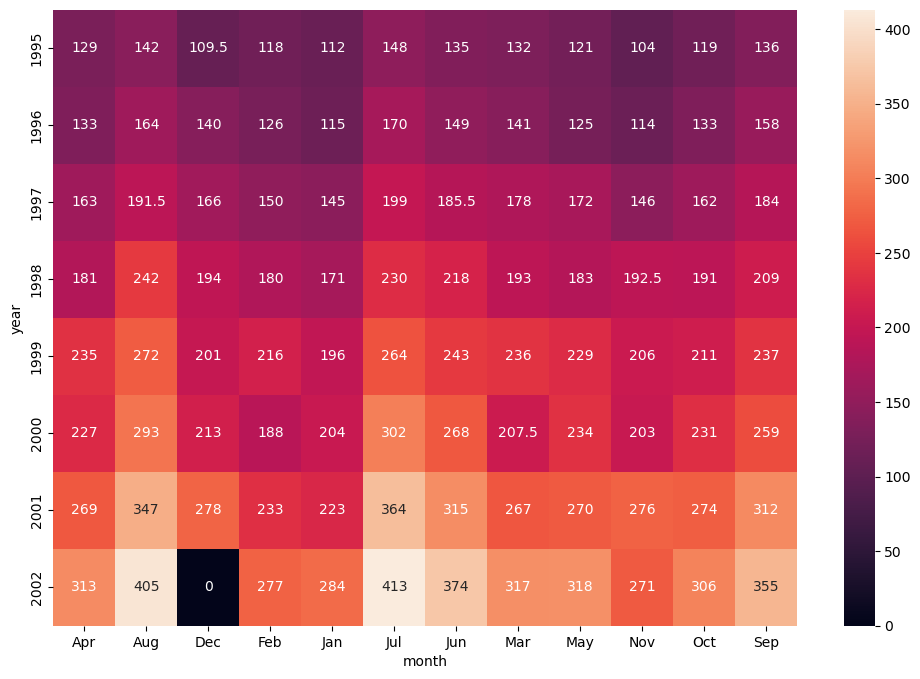

In [49]:
plt.figure(figsize=(12,8))
heatmap_year_month = pd.pivot_table(data=new_df,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_year_month,annot=True,fmt="g")

<AxesSubplot: xlabel='year', ylabel='Passengers'>

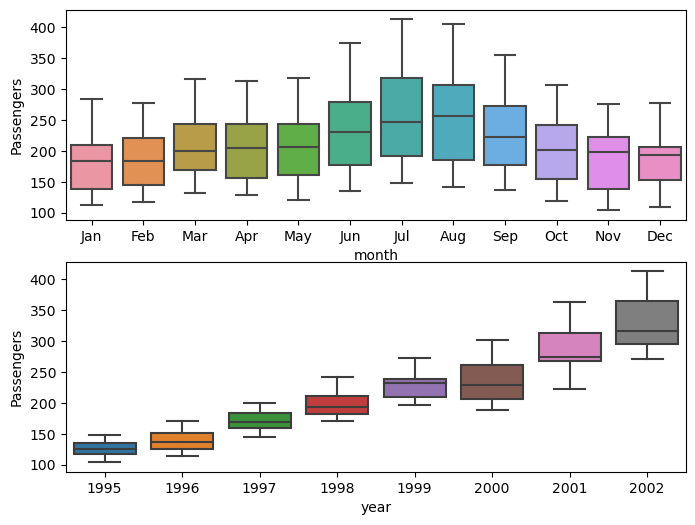

In [50]:
# Boxplot 
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
sns.boxplot(x="month",y="Passengers",data= new_df)
plt.subplot(2,1,2)
sns.boxplot(x="year",y="Passengers",data=new_df)

<AxesSubplot: xlabel='year', ylabel='Passengers'>

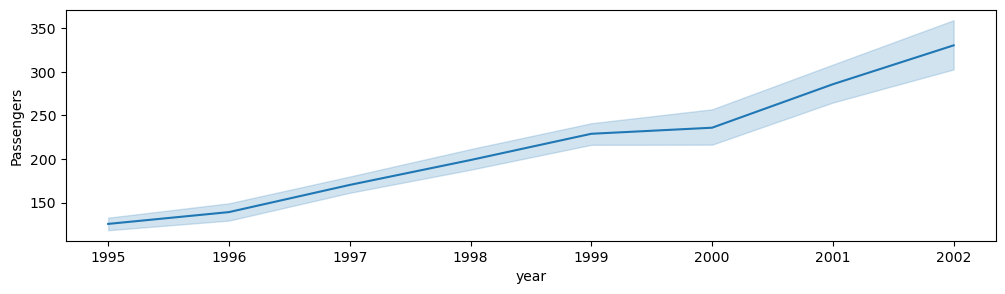

In [51]:
plt.figure(figsize=(12, 3))
sns.lineplot(x="year", y="Passengers", data=new_df)

### Splitting data

In [52]:
train = new_df.iloc[:-20]
test = new_df.iloc[-20:]

In [53]:
train

,Month,Passengers,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
0,1995-01-31,112.0,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1,1995-02-28,118.0,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
2,1995-03-31,132.0,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
3,1995-04-30,129.0,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
4,1995-05-31,121.0,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2000-11-30,203.0,71,5041,Nov,2000,0,0,0,0,0,0,0,0,0,0,1,0,5.313206
71,2000-12-31,213.0,72,5184,Dec,2000,0,0,0,0,0,0,0,0,0,0,0,1,5.361292
72,2001-01-31,223.0,73,5329,Jan,2001,1,0,0,0,0,0,0,0,0,0,0,0,5.407172
73,2001-02-28,233.0,74,5476,Feb,2001,0,1,0,0,0,0,0,0,0,0,0,0,5.451038


In [54]:
test

,Month,Passengers,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
75,2001-04-30,269.0,76,5776,Apr,2001,0,0,0,1,0,0,0,0,0,0,0,0,5.594711
76,2001-05-31,270.0,77,5929,May,2001,0,0,0,0,1,0,0,0,0,0,0,0,5.598422
77,2001-06-30,315.0,78,6084,Jun,2001,0,0,0,0,0,1,0,0,0,0,0,0,5.752573
78,2001-07-31,364.0,79,6241,Jul,2001,0,0,0,0,0,0,1,0,0,0,0,0,5.897154
79,2001-08-31,347.0,80,6400,Aug,2001,0,0,0,0,0,0,0,1,0,0,0,0,5.849325
80,2001-09-30,312.0,81,6561,Sep,2001,0,0,0,0,0,0,0,0,1,0,0,0,5.743003
81,2001-10-31,274.0,82,6724,Oct,2001,0,0,0,0,0,0,0,0,0,1,0,0,5.613128
82,2001-11-30,276.0,83,6889,Nov,2001,0,0,0,0,0,0,0,0,0,0,1,0,5.620401
83,2001-12-31,278.0,84,7056,Dec,2001,0,0,0,0,0,0,0,0,0,0,0,1,5.627621
84,2002-01-31,284.0,85,7225,Jan,2002,1,0,0,0,0,0,0,0,0,0,0,0,5.648974


### Linear Model

In [55]:
linear_model = smf.ols('Passengers~t',data=train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = np.sqrt(mean_squared_error(test['Passengers'],pred_linear))
rmse_linear

57.11999552613017

### Exponential

In [56]:
Exp = smf.ols('log_passengers~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp =  np.sqrt(mean_squared_error(test['Passengers'],pred_Exp))
rmse_Exp

314.3332120612749

### Quadratic 


In [57]:
Quad = smf.ols('Passengers~t+t_sq',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_sq"]]))
rmse_Quad = np.sqrt(mean_squared_error(test['Passengers'],pred_Quad))
rmse_Quad

64.611211991408

### Additive seasonality 

In [58]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(mean_squared_error(test['Passengers'],pred_add_sea))
rmse_add_sea

132.53836786190968

### Additive Seasonality Quadratic 


In [59]:
add_sea_Quad = smf.ols('Passengers~t+t_sq+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sq']]))
rmse_add_sea_quad = np.sqrt(mean_squared_error(test['Passengers'],pred_add_sea_quad))
rmse_add_sea_quad

47.222495941236595

### Multiplicative Seasonality

In [60]:
Mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(mean_squared_error(test['Passengers'],pred_Mult_sea))
rmse_Mult_sea

314.82475925085214

### Multiplicative Additive Seasonality 

In [61]:
Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = np.sqrt(mean_squared_error(test['Passengers'],pred_Mult_add_sea))
rmse_Mult_add_sea

314.2957670942286

## Compareing the results 

In [62]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,47.222496
0,rmse_linear,57.119996
2,rmse_Quad,64.611212
3,rmse_add_sea,132.538368
6,rmse_Mult_add_sea,314.295767
1,rmse_Exp,314.333212
5,rmse_Mult_sea,314.824759


# Additive Seasonality Quadratic model will be prefered  

---------------------------------------------------------------------------------------------------------------------------

# (2) Coco COla Sales

In [63]:
df = pd.read_excel("D:\Assignment\Forecasting\CocaCola_Sales_Rawdata.xlsx", header=0, parse_dates=True)
df

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [65]:
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))

In [66]:
df

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


In [67]:
# converting into datetime formate as the index was not in correct formate.
df['date'] = (pd.to_datetime(df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))

In [68]:
df

,Quarter,Sales,Quarter_Year,date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Quarter       42 non-null     object        
 1   Sales         42 non-null     float64       
 2   Quarter_Year  42 non-null     object        
 3   date          42 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.4+ KB


In [70]:
# Droping the Column Quarter and Quarter_Year from the data set 
# We had get our required date time column and no need for object coumn

In [71]:
df.drop(columns=['Quarter','Quarter_Year'],inplace=True)

In [72]:
df

,Sales,date
0,1734.827000,1986-01-01
1,2244.960999,1986-04-01
2,2533.804993,1986-07-01
3,2154.962997,1986-10-01
4,1547.818996,1987-01-01
5,2104.411995,1987-04-01
6,2014.362999,1987-07-01
7,1991.746998,1987-10-01
8,1869.049999,1988-01-01
9,2313.631996,1988-04-01


In [73]:
df.isna().sum()

Sales    0
date     0
dtype: int64

In [74]:
df.duplicated().sum()

0

In [75]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [76]:
# Converted date column to index
df.set_index('date',inplace=True)

In [77]:
df.head()

,Sales
date,
1986-01-01,1734.827000
1986-04-01,2244.960999
1986-07-01,2533.804993
1986-10-01,2154.962997
1987-01-01,1547.818996


In [78]:
df.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='date')

<AxesSubplot: xlabel='date'>

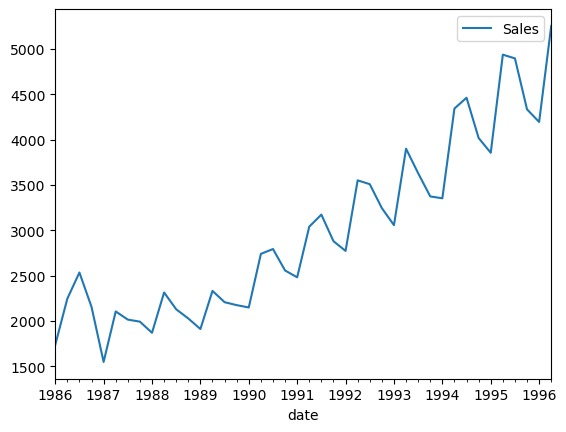

In [79]:
# Line lot
df.plot()

array([[<AxesSubplot: title={'center': 'Sales'}>]], dtype=object)

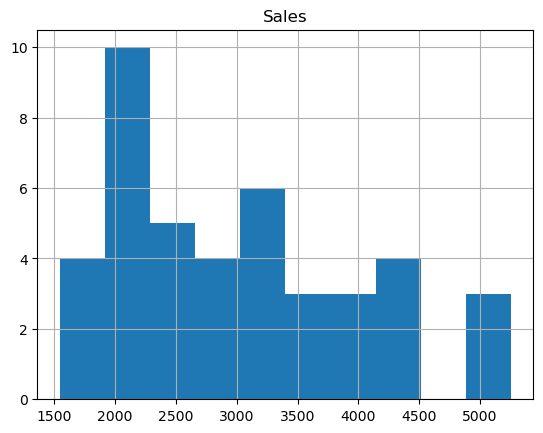

In [80]:
df.hist()

<AxesSubplot: ylabel='Density'>

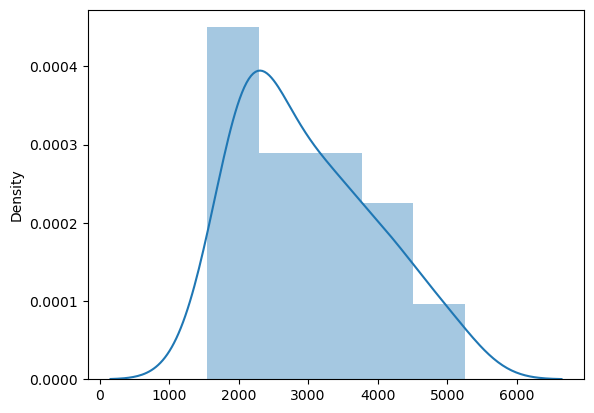

In [81]:
sns.distplot(df)

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

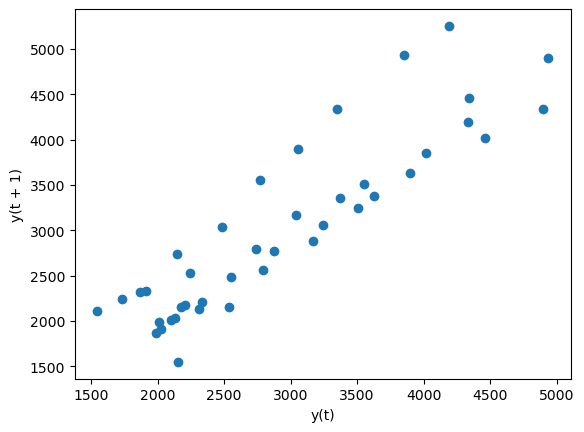

In [82]:
# Lag plot
lag_plot(df)

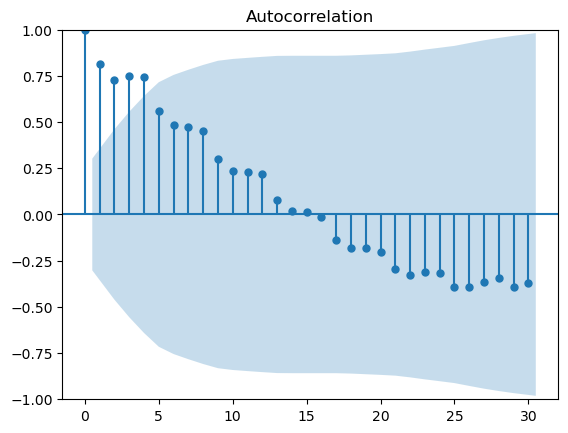

In [83]:
#Autocorrelation Plot
plot_acf(df, lags=30)
plt.show()

### UpSampling

In [84]:
df = df.resample('M').mean()
df.head(12)

,Sales
date,
1986-01-31,1734.827000
1986-02-28,NaN
1986-03-31,NaN
1986-04-30,2244.960999
1986-05-31,NaN
1986-06-30,NaN
1986-07-31,2533.804993
1986-08-31,NaN
1986-09-30,NaN


                  Sales
date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330


<AxesSubplot: xlabel='date'>

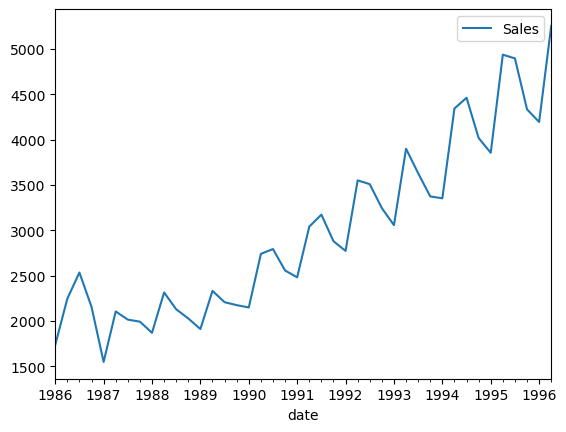

In [85]:
# interplation was done for nan values which we get after doing upsampling by month
df = df.interpolate(method='linear') 
print(df.head(12))
df.plot()

In [86]:
df

,Sales
date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


### Tranformations

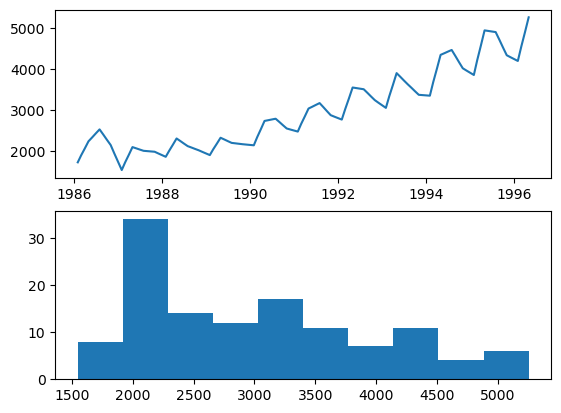

In [87]:
# line plot
plt.subplot(2,1,1)
plt.plot(df)

# histogram
plt.subplot(2,1,2)
plt.hist(df)
plt.show()

### Square Root Transform

In [88]:
sqrt_df = pd.DataFrame(df.values,columns=['Sales'])
sqrt_df['Sales'] = np.sqrt(sqrt_df['Sales'])

<AxesSubplot: xlabel='Sales', ylabel='Density'>

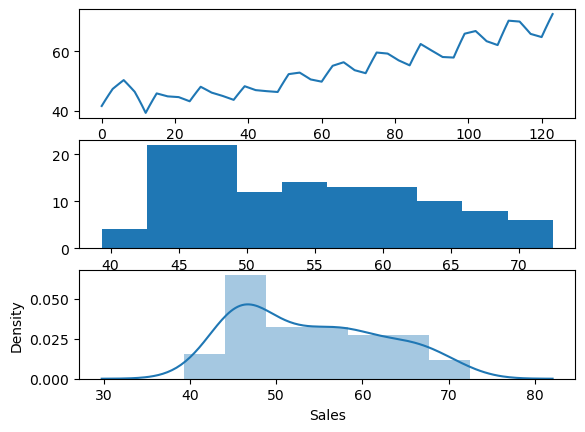

In [89]:
# line plot
plt.subplot(3, 1, 1)
plt.plot(sqrt_df['Sales'])

# histogram
plt.subplot(3, 1, 2)
plt.hist(sqrt_df['Sales'])

# Distplot
plt.subplot(3, 1, 3)
sns.distplot(sqrt_df['Sales'])

### Log Transform

<AxesSubplot: xlabel='Sales', ylabel='Density'>

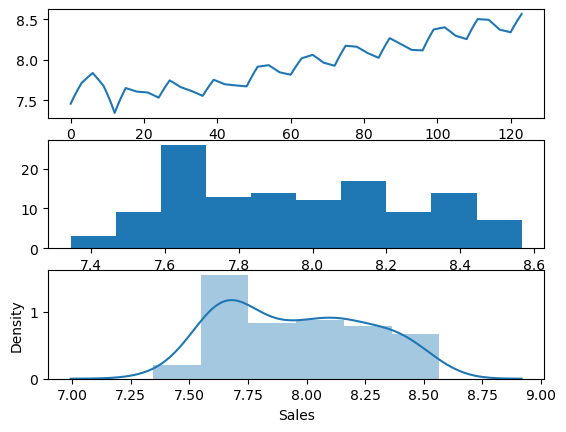

In [90]:
log_df = pd.DataFrame(df.values,columns=['Sales'])
log_df['Sales'] = np.log(log_df['Sales'])

# line plot
plt.subplot(3, 1, 1)
plt.plot(log_df['Sales'])

# histogram
plt.subplot(3, 1, 2)
plt.hist(log_df['Sales'])

# Distplot
plt.subplot(3, 1, 3)
sns.distplot(log_df['Sales'])

In [91]:
df

,Sales
date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


In [92]:
train = df.iloc[:-20]
test = df.iloc[-20:]

In [93]:
train

,Sales
date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1994-04-30,4342.000000
1994-05-31,4381.666667
1994-06-30,4421.333333


In [94]:
test

,Sales
date,
1994-09-30,4165.000000
1994-10-31,4017.000000
1994-11-30,3962.666667
1994-12-31,3908.333333
1995-01-31,3854.000000
1995-02-28,4214.666667
1995-03-31,4575.333333
1995-04-30,4936.000000
1995-05-31,4922.333333


### Time series decomposition plot

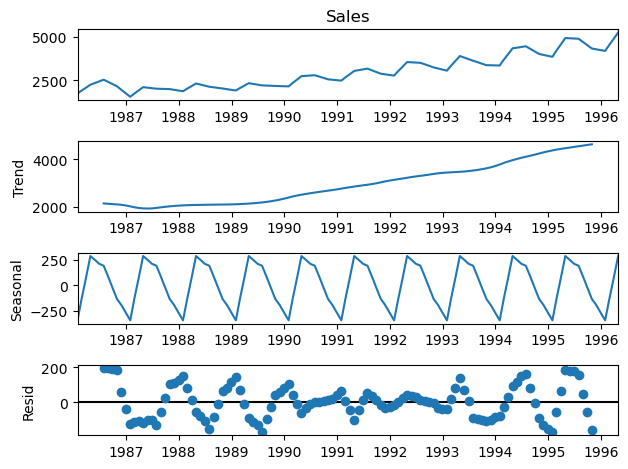

In [95]:
df_ts = seasonal_decompose(df.Sales)  
df_ts.plot()
plt.show()

### ACF plots and PACF plots

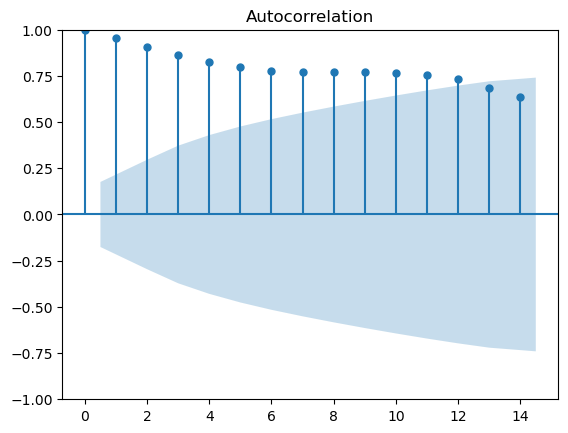

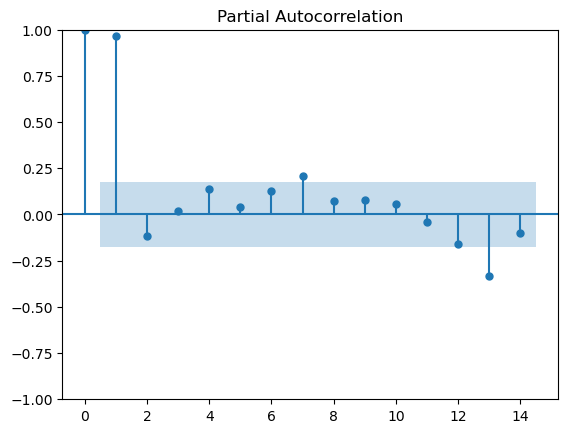

In [96]:
plot_acf(df.Sales,lags=14)
plot_pacf(df.Sales,lags=14)
plt.show()

## Model Evaluation

#### Simple Exponential Method

In [97]:
se_model = SimpleExpSmoothing(train["Sales"]).fit(smoothing_level=0.2)
pred_se = se_model.predict(start=test.index[0], end=test.index[-1])

test['Sales'].mean()
rmse=sqrt(mean_squared_error(pred_se,test['Sales']))

print('RMSE :', rmse)

RMSE : 526.0912750196305


#### Holt method

In [98]:
ht_model = Holt(train["Sales"]).fit(smoothing_level=0.1, smoothing_slope=0.2)
pred_ht = ht_model.predict(start = test.index[0],end = test.index[-1])

test['Sales'].mean()
rmse=sqrt(mean_squared_error(pred_ht,test['Sales']))

print('RMSE :', rmse)

RMSE : 461.17195754524096


#### Holts winter exponential smoothing with additive seasonality and additive trend

In [99]:
hwe_model_add_add = ExponentialSmoothing(train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.2)
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])

rmse=sqrt(mean_squared_error(pred_hwe_add_add,test['Sales']))

print('RMSE :', rmse)

RMSE : 231.7910794417683


#### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [100]:
hwe_model_mul_add = ExponentialSmoothing(train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.2)
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])

rmse=sqrt(mean_squared_error(pred_hwe_mul_add,test['Sales']))

print('RMSE :', rmse)

RMSE : 106.9523871867563


#### Final Model by combining train and test

In [101]:
hwe_model_mul_add = ExponentialSmoothing(df["Sales"],seasonal="mul",trend="add",seasonal_periods=10).fit()

#Forecasting for next 10 time periods
hwe_model_mul_add.forecast(10)

1996-05-31    5590.250432
1996-06-30    5939.056613
1996-07-31    6233.654696
1996-08-31    6533.609246
1996-09-30    6744.888679
1996-10-31    7071.579217
1996-11-30    7326.458843
1996-12-31    7783.224562
1997-01-31    8093.368230
1997-02-28    8474.521620
Freq: M, dtype: float64

In [102]:
df

,Sales
date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


In [103]:
df.reset_index(inplace=True)

In [104]:
df['t'] = 1

In [105]:
for i,row in df.iterrows():
    df['t'].iloc[i] = i+1
    
df

,date,Sales,t
0,1986-01-31,1734.827000,1
1,1986-02-28,1904.871666,2
2,1986-03-31,2074.916332,3
3,1986-04-30,2244.960999,4
4,1986-05-31,2341.242330,5
...,...,...,...
119,1995-12-31,4240.333333,120
120,1996-01-31,4194.000000,121
121,1996-02-29,4547.000000,122
122,1996-03-31,4900.000000,123


In [106]:
# inserted t_sq column with values
df['t_sq'] = np.square(df['t'])

In [107]:
df

,date,Sales,t,t_sq
0,1986-01-31,1734.827000,1,1
1,1986-02-28,1904.871666,2,4
2,1986-03-31,2074.916332,3,9
3,1986-04-30,2244.960999,4,16
4,1986-05-31,2341.242330,5,25
...,...,...,...,...
119,1995-12-31,4240.333333,120,14400
120,1996-01-31,4194.000000,121,14641
121,1996-02-29,4547.000000,122,14884
122,1996-03-31,4900.000000,123,15129


In [108]:
df["month"] = df.date.dt.strftime("%b") # month extraction
df["year"] = df.date.dt.strftime("%Y") # year extraction

In [109]:
df

,date,Sales,t,t_sq,month,year
0,1986-01-31,1734.827000,1,1,Jan,1986
1,1986-02-28,1904.871666,2,4,Feb,1986
2,1986-03-31,2074.916332,3,9,Mar,1986
3,1986-04-30,2244.960999,4,16,Apr,1986
4,1986-05-31,2341.242330,5,25,May,1986
...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995
120,1996-01-31,4194.000000,121,14641,Jan,1996
121,1996-02-29,4547.000000,122,14884,Feb,1996
122,1996-03-31,4900.000000,123,15129,Mar,1996


In [110]:
# converting the dummy variables for month column
months = pd.get_dummies(df['month']) 

In [111]:
months

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
119,0,0,1,0,0,0,0,0,0,0,0,0
120,0,0,0,0,1,0,0,0,0,0,0,0
121,0,0,0,1,0,0,0,0,0,0,0,0
122,0,0,0,0,0,0,0,1,0,0,0,0


In [112]:
# storing the months as serial wise again in months variable
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]

In [113]:
df = pd.concat([df,months],axis=1)

In [114]:
df.head()

,date,Sales,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0


In [115]:
df['log_sales'] = np.log(df['Sales'])

In [116]:
df.head()

,date,Sales,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437


<AxesSubplot: xlabel='month', ylabel='year'>

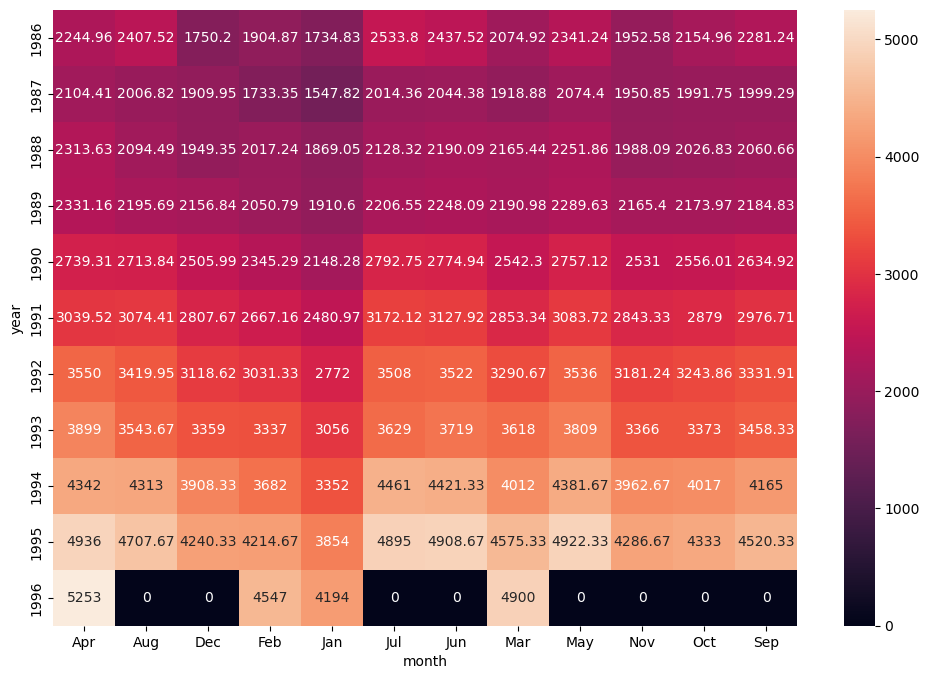

In [117]:
# Heatmap
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=df,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

<AxesSubplot: xlabel='year', ylabel='Sales'>

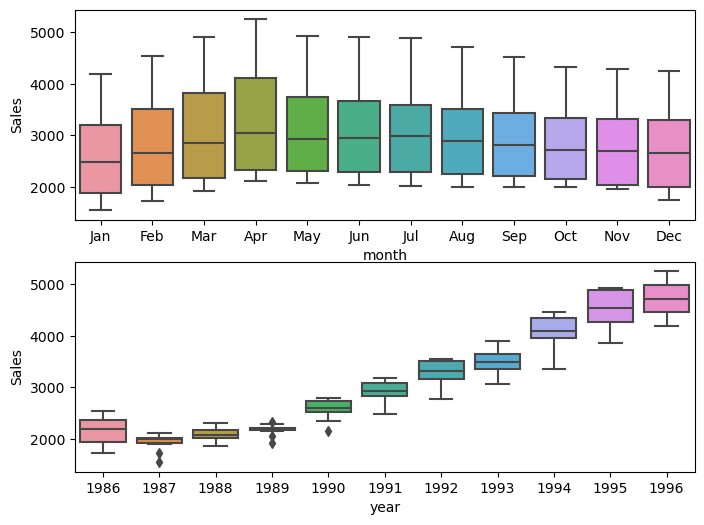

In [118]:
# Boxplot
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
sns.boxplot(x="month", y="Sales", data=df)
plt.subplot(2, 1, 2)
sns.boxplot(x="year", y="Sales", data=df)

<AxesSubplot: xlabel='year', ylabel='Sales'>

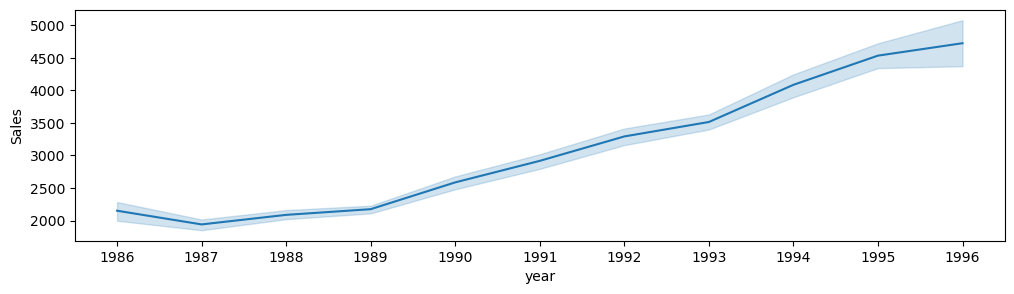

In [119]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="Sales",data=df)

### Splitting data

In [120]:
train = df.iloc[:-20] # training data
test = df.iloc[-20:] # test Data

In [121]:
train

,date,Sales,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,1994-04-30,4342.000000,100,10000,Apr,1994,0,0,0,1,0,0,0,0,0,0,0,0,8.376090
100,1994-05-31,4381.666667,101,10201,May,1994,0,0,0,0,1,0,0,0,0,0,0,0,8.385184
101,1994-06-30,4421.333333,102,10404,Jun,1994,0,0,0,0,0,1,0,0,0,0,0,0,8.394197
102,1994-07-31,4461.000000,103,10609,Jul,1994,0,0,0,0,0,0,1,0,0,0,0,0,8.403128


In [122]:
test

,date,Sales,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
104,1994-09-30,4165.000000,105,11025,Sep,1994,0,0,0,0,0,0,0,0,1,0,0,0,8.334472
105,1994-10-31,4017.000000,106,11236,Oct,1994,0,0,0,0,0,0,0,0,0,1,0,0,8.298291
106,1994-11-30,3962.666667,107,11449,Nov,1994,0,0,0,0,0,0,0,0,0,0,1,0,8.284672
107,1994-12-31,3908.333333,108,11664,Dec,1994,0,0,0,0,0,0,0,0,0,0,0,1,8.270866
108,1995-01-31,3854.000000,109,11881,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,8.256867
109,1995-02-28,4214.666667,110,12100,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,8.346326
110,1995-03-31,4575.333333,111,12321,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,8.428435
111,1995-04-30,4936.000000,112,12544,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,8.504311
112,1995-05-31,4922.333333,113,12769,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,8.501538
113,1995-06-30,4908.666667,114,12996,Jun,1995,0,0,0,0,0,1,0,0,0,0,0,0,8.498758


### Linear Model

In [123]:
linear_model = smf.ols('Sales~t',data=train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = np.sqrt(mean_squared_error(test['Sales'],pred_linear))
rmse_linear

569.7843001677297

### Exponential

In [124]:

Exp = smf.ols('log_sales~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = np.sqrt(mean_squared_error(test['Sales'],pred_Exp))
rmse_Exp

4476.418840709796

### Quadratic 


In [125]:
Quad = smf.ols('Sales~t+t_sq',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_sq"]]))
rmse_Quad = np.sqrt(mean_squared_error(test['Sales'],pred_Quad))
rmse_Quad

461.57570568979594

### Additive seasonality

In [126]:
add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(mean_squared_error(test['Sales'],pred_add_sea))
rmse_add_sea

1831.8101221834681

### Additive Seasonality Quadratic 

In [127]:
add_sea_Quad = smf.ols('Sales~t+t_sq+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sq']]))
rmse_add_sea_quad = np.sqrt(mean_squared_error(test['Sales'],pred_add_sea_quad))
rmse_add_sea_quad

282.66236094552534

### Multiplicative Seasonality

In [128]:
Mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(mean_squared_error(test['Sales'],pred_Mult_sea))
rmse_Mult_sea

4476.906333256552

### Multiplicative Additive Seasonality

In [129]:
Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = np.sqrt(mean_squared_error(test['Sales'],pred_Mult_add_sea))
rmse_Mult_add_sea

4476.43275070616

### Compareing the results

In [130]:
data = {
    "MODEL" : pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
    "RMSE_Values" : pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,282.662361
2,rmse_Quad,461.575706
0,rmse_linear,569.784300
3,rmse_add_sea,1831.810122
1,rmse_Exp,4476.418841
6,rmse_Mult_add_sea,4476.432751
5,rmse_Mult_sea,4476.906333


# Additive Seasonality Quadratic will be prefered